# Prerequisite Knowledge

## Basic

Audio is represented digitally by coverting the produced waves of air pressure into voltage via a microphone and sampled with an analog-to-digital converter. Output of the recording process is a 1-dimensional array of numbers representing the discrete samples from the digital conversion. Digitized signal has three main properties:
- sample rate: the frequency at which the analog signal is sampled (in Hertz)
- number of channels: refers to number of microphones by which the audio is captured (single channel audio is mono and two-channel is stereo)
- precision/bit depth: number of bits per sample (sound resolution)

Standard telephone audio has a sampling rate of 8kHz and 16 bit precision. CD quality is 44.1kHz, 16 bit precision. Speech processing usually focuses on 16kHz or higher.

Sometimes bit rate is used to measure overall quality of audio:  
bit rate = sample rate x precision x number_of_channels

Raw speech signal is high dimensional and difficult to model. Most ASR systems rely on features extracted from the audio signal to reduce the dimensionality and filter unwanted signals. Many of these features come from some form of spectral analysis that converts the audio signal to a set of features that strenghten signals that mimic the human ear. Many of these methods depend on computing STFT on audio signal using FFT, filter banks, or some combination of two.

## MFCC
Mel frequency cepstral coefficients are the most commonly used features for ASR. Their success relies upon their ability to perfrom similar types of filtering that correlates to the human auditory system and their low dimensionality. One downside of MFCC is the sensitivity to noise due to its dependence on the spectral form. Lower dimensionality of the feature space is a benefit (at the cost of resolution)

There are 7 steps to computing the MFCC features. These steps are similar for most feature generation techniques, with some variability in the types of filters that are used and the filter banks applied.
- Pre-emphasis
- Framing
- Hamming windowing
- FFT
- Mel filter bank processing
- Discrete cosine transform (DCT)
- Delta enery and delta spectrum 

### Pre-emphasis
In speech production the energy of higher frequency signals tends to be lower. Pre-emphasis applies a filter to input signal that emphasizes the amplitudes of higher frequencies and lowers the amplitude of lower frequencies

### Framing
Framing is the process of seperating the samples from the raw audio into fixed length segments (treated as stationary) referred to as frames. These segments are converted to the frequency domain with an FFT, yielding a representation of the strenght of frequencies during each frame. The segments signify the boundaries between the phonetic representations of speech. The phonetic sounds associated with speech tend to be in the range of 5-100ms, so the lenght of frames is usually chosen to account for this. Typically, frames are in the range of 20ms for most ASR systems, with a 10ms overlap, yielding a resolution of 10ms for our frames.

### Windowing
Windowing multiplies the samples by a scaling function. The purpose of this function is to smooth the potentially abrupt effects of framing that ca cause sharp differences at the edges of frames. Applying windowing functions to the samples therefore tapers the changes to the segment to dampen signals near the edges of the frame that may have harsh effects after the application of the FFT.  Most commonly used for ASR are Hann windowing and Hamming windowing.

### FFT
STFT converst the 1-dimensional signal from the time domain into the frequency domain by using the frames and applying a DFT to each. FFT is an efficient algorithm to compute the DFT and is common for ASR. Spectrogram is a 3-dimensional visual FFt transformation of the acoustic signal and is often a valuable set of features itself. ITFT representation can be advantageous because it makes the fewest assumptions about the speech signal (aside from the raw wavefrom). For some end-to-end systems the spectrogram is used as input, because it provides a higher resolution frequency description.

Most of the significant frequencies are in the lower portion of the frequency spectrum, so the spectrogram is typically mapped into the log scale.

### Mel Filter Bank
The features created from the STFT aim to simulate conversions made by the human auditory system. The Mel filter bank is a set of bandpass filters that mimic the human auditory system. The filter bank usually has 40 filters. Each filter produces an output that is the weighted sum of the spectral frequencies that correspond to each filter. These values map the input frequencies into the Mel scale.

### Discrete Cosine Transform
The DCT maps the Mel scale features into the time domain. Similar to Fourier transform but uses only real numbers. Output of this is refreed to as MFCC

### Delta enery and delta spectrum
Provide information about the slope of the transition between frames.

## Some references of values used
- Tacotron2: 
    - max_wav_value=32768.0
    - sampling_rate=22050
    - filter_length=1024
    - hop_length=256
    - win_length=1024
    - n_mel_channels=80
    - mel_fmin=0.0
    - mel_fmax=8000.0
- Pytorch tutorial MFCC:
    - n_fft = 2048
    - win_length = None
    - hop_length = 512
    - n_mels = 256
    - n_mfcc = 256
- Pytorch tutorial MelSpectrogram:
    -sample_rate=sample_rate,
    - n_fft=1024,
    - win_length=None,
    - hop_length=512,
    - center=True,
    - pad_mode="reflect",
    - power=2.0,
    - norm='slaney',
    - onesided=True,
    - n_mels=128,
    - mel_scale="htk",
- DSP background:
    - this window lenght and step size is usual
    - sampling rate is 16khz
    - window lenght is 25ms (25*10^-3 * 16000 = 400)
    - step size is 10 ms (... = 160 samples)
    - N FFT = 512 samples
    - hamming window is usually used



## Audio/Speech Common Terms:
    - Amplitude: Amplitude of Sound. The strength or level of sound pressure. The amplitude of a sound wave determines its loudness or volume.
    - Reverberation (similar to echo): It is a persistence of sound after the sound is produced. A reverberation, or reverb, is created when a sound or signal is reflected causing numerous reflections to build up and then decay as the sound is absorbed by the surfaces of objects in the space
    - Pitch: the quality of a sound governed by the rate of vibrations producing it; the degree of highness or lowness of a tone.



# Audio EDA

#### Note: EDA is done on raw audio files without resampling and channel reduction which will be needed in training

In [29]:
import os
import pydub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import librosa
import numpy as np
import IPython

In [2]:
DATA_FOLDER_PTH=os.path.join(os.getcwd(), os.pardir, 'data')

# processed
TRAIN_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'processed/MELD/train_wavs')
DEV_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'processed/MELD/dev_wavs')
TEST_AUDIO_FOLDER_PTH=os.path.join(DATA_FOLDER_PTH, 'processed/MELD/test_wavs')

In [3]:
if os.path.exists(os.path.join(os.getcwd(),os.pardir,'data/processed/MELD/train_wavs_stats.csv'))==False:
    audio_data=pd.DataFrame(columns=['sample_rate','channels','bits_pre_sample','duration','codec_long_name','size'])
    for audio_name in os.listdir(TRAIN_AUDIO_FOLDER_PTH):
        audio_pth=os.path.join(TRAIN_AUDIO_FOLDER_PTH,audio_name)
        info=pydub.utils.mediainfo(audio_pth)
        
        data={
            'audio_name':audio_name,
            'sample_rate':int(info['sample_rate']),
            'channels':int(info['channels']),
            'bits_pre_sample':int(info['bits_per_sample']),
            'duration': float(info['duration']),
            'codec_long_name':str(info['codec_long_name']),
            'size':int(info['size'])
        }
        
        audio_data=audio_data.append(data,ignore_index=True)
    audio_data.to_csv(os.path.join(os.getcwd(),os.pardir,'data/processed/MELD/train_wavs_stats.csv'),index=False)
else:
    audio_data=pd.read_csv(os.path.join(os.getcwd(),os.pardir,'data/processed/MELD/train_wavs_stats.csv'))

In [4]:
audio_data.head()

sample_rate  channels  bits_pre_sample  duration  \
0        48000         2               16  5.674667   
1        48000         2               16  1.472000   
2        48000         2               16  2.005333   
3        48000         2               16  8.320000   
4        48000         2               16  3.050667   

                   codec_long_name     size      audio_name  
0  PCM signed 16-bit little-endian  1089614   dia0_utt0.wav  
1  PCM signed 16-bit little-endian   282702   dia0_utt1.wav  
2  PCM signed 16-bit little-endian   385102  dia0_utt10.wav  
3  PCM signed 16-bit little-endian  1597518  dia0_utt11.wav  
4  PCM signed 16-bit little-endian   585806  dia0_utt12.wav

In [5]:
audio_data.describe()

sample_rate     channels  bits_pre_sample     duration          size
count       9988.0  9988.000000           9988.0  9988.000000  9.988000e+03
mean       48000.0     5.552663             16.0     3.142124  1.670729e+06
std            0.0     1.260713              0.0     2.428665  1.375472e+06
min        48000.0     2.000000             16.0     0.064000  1.236600e+04
25%        48000.0     6.000000             16.0     1.557333  7.742460e+05
50%        48000.0     6.000000             16.0     2.474667  1.278054e+06
75%        48000.0     6.000000             16.0     3.925333  2.113638e+06
max        48000.0     6.000000             16.0    41.045333  2.364221e+07

In [8]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_rate      9988 non-null   int64  
 1   channels         9988 non-null   int64  
 2   bits_pre_sample  9988 non-null   int64  
 3   duration         9988 non-null   float64
 4   codec_long_name  9988 non-null   object 
 5   size             9988 non-null   int64  
 6   audio_name       9988 non-null   object 
dtypes: float64(1), int64(4), object(2)
memory usage: 546.3+ KB


In [9]:
audio_data.nunique()

sample_rate           1
channels              2
bits_pre_sample       1
duration            466
codec_long_name       1
size                765
audio_name         9988
dtype: int64

#### Note: Not everything is 2 channel audio

## Inspect channels

In [10]:
audio_data.channels.unique()

array([2, 6], dtype=int64)

In [11]:
print(len(audio_data[audio_data.channels==6]))
print(len(audio_data[audio_data.channels==2]))
# Comment: most is 6 channel actually

8871
1117


In [35]:
audio_data[audio_data.channels==6].sample(2)

sample_rate  channels  bits_pre_sample  duration  \
1297        48000         6               16  2.730667   
1190        48000         6               16  2.517333   

                      codec_long_name     size        audio_name  
1297  PCM signed 16-bit little-endian  1572966  dia183_utt18.wav  
1190  PCM signed 16-bit little-endian  1450086   dia175_utt2.wav

In [79]:
audio_file_pth=audio_file_pth=os.path.join(TRAIN_AUDIO_FOLDER_PTH,'dia175_utt2.wav')

In [80]:
y,sr=torchaudio.load(audio_file_pth, channels_first=True, normalize=True)
y.size()

torch.Size([6, 120832])

In [93]:
import json
def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))
    
channel0=y[5,:].numpy().squeeze()
print(channel0.shape)
Audio(channel0,48000)

(120832,)


#### Note: channel 5 seems to be of the background laugh only, other channels are speaker+laugh

## Trying to seperate laugh track (FAILED)

### Try 1

In [95]:
original_audio=torch.mean(y[0:5,:], dim=0).numpy().squeeze()
laugh_track=y[5,:].numpy().squeeze()

original_audio_fft=torch.stft(torch.mean(y[0:5,:],dim=0), n_fft=1024)
laugh_track_fft=torch.stft(y[5,:], n_fft=1024)

sub=original_audio_fft-laugh_track_fft

inverse=torch.istft(sub, n_fft=1024)


# Audio(subtraction_audio,48000)
Audio(inverse.numpy().squeeze(), sr=22050)

### Try 2

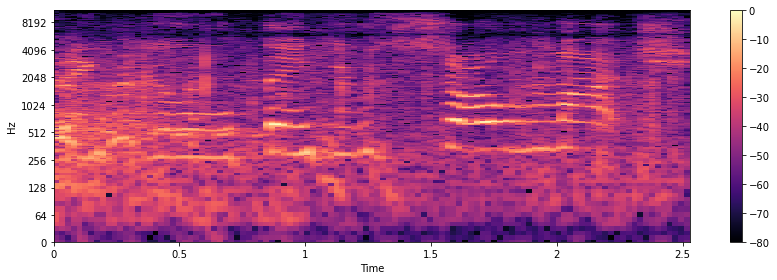

In [58]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display



y, sr = librosa.load(os.path.join(TRAIN_AUDIO_FOLDER_PTH, 'dia175_utt2.wav'))


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

idx = slice(*librosa.time_to_frames([0, 5], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()


In [60]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

In [69]:
new_y=librosa.istft(S_background*phase)
Audio(new_y,22050)

In [67]:
# Audio(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),22050)
librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max).shape

(1025, 109)

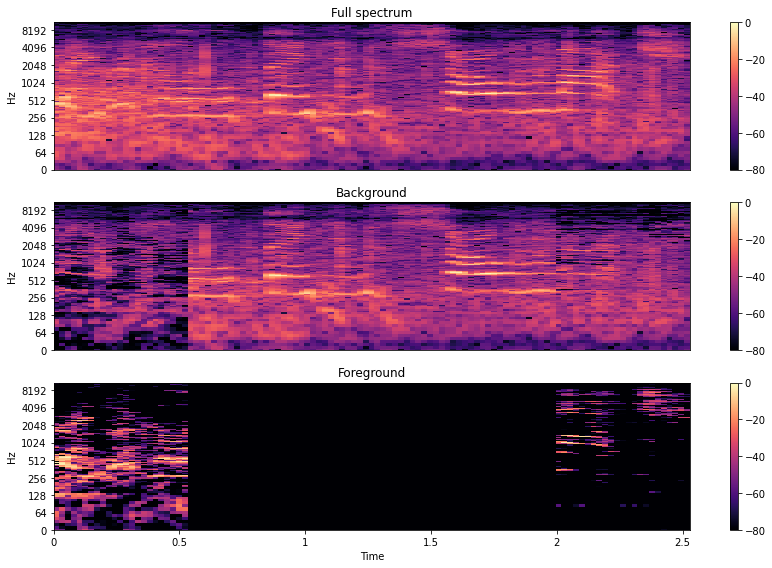

In [61]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [54]:
# Audio(torch.mean(y[0:5,:], dim=0).numpy().squeeze(), 48000)
# Audio(y[5,:].numpy().squeeze(), 48000)

## Inspect duration distribution

<AxesSubplot:xlabel='duration', ylabel='Count'>

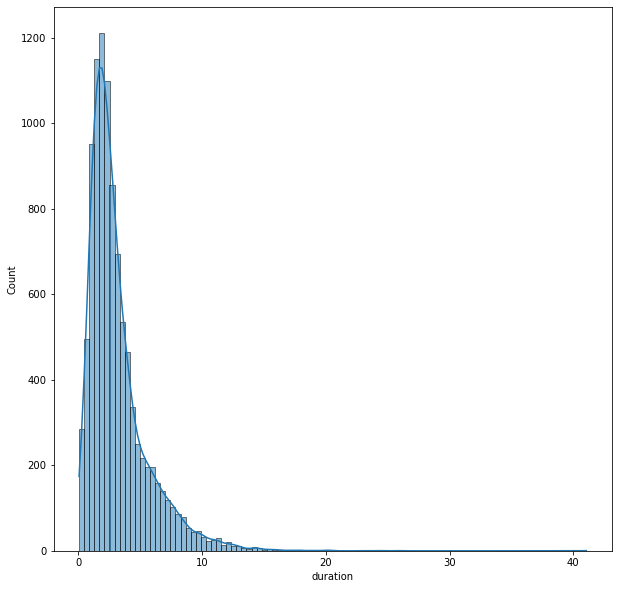

In [15]:
fig,ax=plt.subplots(figsize=(10,10))
sns.histplot(ax=ax, data=audio_data.duration, kde=True, bins=100)

# Feature Extraction with PyTorch

In [16]:
import torchaudio
import glob

print(torchaudio.get_audio_backend())

soundfile


In [17]:
audio_file_pth=glob.glob(os.path.join(TRAIN_AUDIO_FOLDER_PTH,'*.wav'))[0]
audio_file_pth

'e:\\machine_learning\\projects\\multimodal-emotion-classification\\notebooks\\..\\data\\processed/MELD/train_wavs\\dia0_utt0.wav'

## Utils

In [18]:


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

## Getting info

In [19]:
info=torchaudio.info(audio_file_pth)
print(info)

AudioMetaData(sample_rate=48000, num_frames=272384, num_channels=2, bits_per_sample=16, encoding=PCM_S)


## Loading audio 

In [20]:
# normalize arg: normalizes values from -1.0 to 1.0

y,sr=torchaudio.load(audio_file_pth, channels_first=True, normalize=True)
print('Audio Tensor', y)
print('Audio Tensor size', y.size())

Audio Tensor tensor([[-5.4932e-03, -1.3977e-02, -3.0731e-02,  ..., -3.9673e-04,
         -6.1035e-05, -6.1035e-05],
        [ 6.4087e-04, -6.1035e-04, -8.6365e-03,  ..., -9.1553e-05,
          2.7466e-04,  1.2207e-04]])
Audio Tensor size torch.Size([2, 272384])


## Resample with pytorch

In [21]:
resampler=torchaudio.transforms.Resample(orig_freq=48000, new_freq=22050)
print(y.size())
y_resampled=resampler(y)
print(y_resampled.size())

torch.Size([2, 272384])
torch.Size([2, 125127])


## Change to mono

In [22]:
y_resampled_mono=torch.mean(y_resampled, dim=0).unsqueeze(0)
print(y_resampled_mono.size())

torch.Size([1, 125127])


## Get Mel Spectrogram 

torch.Size([1, 128, 245])


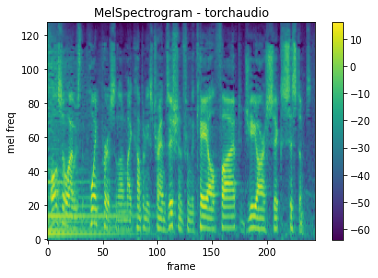

In [23]:
mel_spectrogram=torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode='reflect',
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=128,
    mel_scale="htk"
)

y_mel_spec=mel_spectrogram(y_resampled_mono)
print(y_mel_spec.size())

plot_spectrogram(y_mel_spec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

## Get Pitch

torch.Size([1, 552])


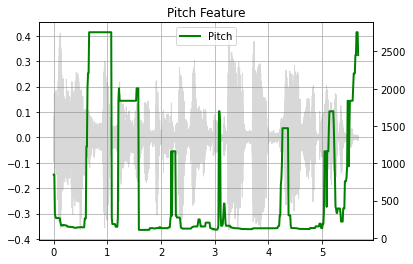

In [24]:
pitch=torchaudio.functional.detect_pitch_frequency(y_resampled_mono, 22050)
print(pitch.size())
plot_pitch(y_resampled_mono, 22050, pitch)

# Get MFCC

mfcc_transform=torchaudio.transforms.MFCC()

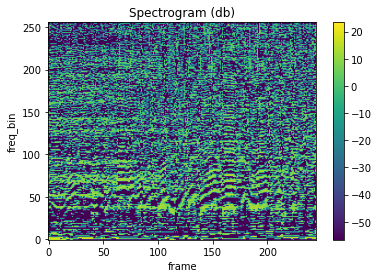

In [27]:
sample_rate=22050
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform=torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc=mfcc_transform(y_resampled_mono)
plot_spectrogram(mfcc[0])